# Population Simulator

In [1]:
import random
from matplotlib import pyplot as plt
from collections import defaultdict

In [85]:
class Individual(object):
    """This class represents an individual."""

    def __init__(self, gamete1, gamete2, sex):
        """
        @param genes1: sequence of alleles on first "chromosome".
        Each allele is a symbol; typically an integer or a random string.
        @param genes2: sequence of alleles on second "chronosome". """
        self.chromosomes = list(zip(gamete1, gamete2))
        self.sex = sex

    @staticmethod
    def create_random(num_genes=1, num_alleles=2, mu=0, highest_allele=1, sex_ratio=0.5):
        genes = [[random.randint(0, num_alleles - 1) for _ in range(num_genes)] for g in range(2)]
        for gene in range(len(genes)):
            for allele in range(len(genes[gene])):
                # maybe mutate
                if random.random() < mu:
                    genes[gene][allele] = highest_allele
        
        gene1, gene2 = genes
        sex = 'f' if random.random() < sex_ratio else 'm'
        return Individual(gene1, gene2, sex)

    def gamete(self, highest_allele, mu):
        """Returns random gamete."""
        genes = [a[random.randint(0, 1)] for a in self.chromosomes]
        for gene in range(len(genes)):
            if random.random() < mu:
                highest_allele += 1 * round(random.random())
                genes[gene] = highest_allele
        return genes, highest_allele

    def __eq__(self, other):
        """Checks for genetic equality."""
        return self.chromosomes == other.chromosomes

    def __repr__(self):
        return str(self.chromosomes)

class Genotype():
    def __init__(self, gene_index, gene):
        self.gene_index = gene_index
        self.gene = gene

    def __repr__(self):
        # gene index = letter, gene # = number
        return f'({chr(self.gene_index + 97)}{self.gene[0]},{chr(self.gene_index + 97)}{self.gene[1]})'

    def __eq__(self, other):
        """Checks for Genotype equality."""
        return self.gene_index == other.gene_index and self.gene == other.gene

    def __hash__(self):
        return hash((self.gene_index, self.gene))

    def get_allele(self, index):
        return Allele(self.gene_index, self.gene[index])

class Allele():
    def __init__(self, gene_index, allele):
        self.gene_index = gene_index
        self.allele = allele

    def __repr__(self):
        # gene index = letter, gene # = number
        return f'{chr(self.gene_index + 97)}{self.allele}'

    def __eq__(self, other):
        """Checks for Genotype equality."""
        return self.gene_index == other.gene_index and self.allele == other.allele

    def __hash__(self):
        return hash((self.gene_index, self.allele))

In [26]:
from collections import defaultdict
class Population(object):
    """This class represents the snapshot of a population."""

    def __init__(self, individuals=None, mu=0, highest_allele=1, unfitness_dict={}, ick_dict={}):
        self.individuals = individuals or []
        self.females, self.males = None, None
        self.gene_frequencies = []
        self.mu = mu
        self.highest_allele = highest_allele
        self.unfitness_dict = unfitness_dict
        self.ick_dict = ick_dict

    def __len__(self):
        return len(self.individuals)

    def __iter__(self):
        return iter(self.individuals)

    def is_monozygotic_for(self, gene):
        """ Returns TRUE if this gene is monozygotic; else FALSE """
        return self.chromosomes[gene][0] == self.chromosomes[gene][1]

    def add(self, individual):
        self.individuals.append(individual)

    def pick_individual(self):
        """Returns a random individual."""
        return random.choice(self.individuals)

    '''
    Selects individual based on their fitness
    param mating_bias_dict: maps genotypes to their chance of getting them unselected for mating
    '''
    def pick_individual_selectively(self):
        """Returns a random individual."""
        while True:
            ick = 0
            ind = random.choice(self.individuals)
            for genotype, badness in self.ick_dict.items():
                if ind.chromosomes[genotype.gene_index] == genotype.gene:
                    ick += badness
            x = random.random()
            if random.random() > ick:
                return ind

    def random_mating(self, sex_ratio=0.5):
        """Returns an individual produced via random mating."""
        g1, highest_allele = self.pick_individual().gamete(self.highest_allele, self.mu)
        self.highest_allele = highest_allele
        g2, highest_allele = self.pick_individual().gamete(self.highest_allele, self.mu)
        self.highest_allele = highest_allele
        sex = 'f' if random.random() < sex_ratio else 'm'
        return Individual(g1, g2, sex)

    def selective_random_mating(self, sex_ratio=0.5):
        """Returns an individual produced via random mating."""
        g1, highest_allele = self.pick_individual_selectively().gamete(self.highest_allele, self.mu)
        self.highest_allele = highest_allele
        g2, highest_allele = self.pick_individual_selectively().gamete(self.highest_allele, self.mu)
        self.highest_allele = highest_allele
        sex = 'f' if random.random() < sex_ratio else 'm'
        return Individual(g1, g2, sex)

    def random_hermaphrodite_mating(self, sex_ratio):
        """Returns an individual generated via non-self mating,
        aka Banana Slug mating."""
        i1, i2 = random.sample(self.individuals, k=2)
        g1, highest_allele = i1.gamete(self.highest_allele, self.mu)
        self.highest_allele = highest_allele
        g2, highest_allele = i2.gamete(self.highest_allele, self.mu)
        self.highest_allele = highest_allele
        sex = 'f' if random.random() < sex_ratio else 'm'
        return Individual(g1, g2, sex)

    def partition_genders_randomly(self, prob=0.5):
        """Partition the population in genders, randomly.
        Returns whether there is at least somebody of both genders."""
        self.males, self.females = [], []
        for x in self.individuals:
            if random.random() < prob:
                self.females.append(x)
            else:
                self.males.append(x)
        return len(self.females) > 0 and len(self.males) > 0

    def random_sexual_mating(self, prob=0.5, sex_ratio=0.5):
        """This is a simple model, in which mating can happen only between
        individuals of opposite sex, and we are given the probability that an
        individual is of a given sex.
        We could do things in another way, but this is ok for now."""
        if self.females is None and self.males is None:
            feasible = self.partition_genders_randomly(prob=prob)
            if not feasible:
                return None
        f = random.choice(self.females)
        m = random.choice(self.males)
        f_gamete, highest_allele = f.gamete(self.highest_allele, self.mu)
        self.highest_allele = highest_allele
        m_gamete, highest_allele = m.gamete(self.highest_allele, self.mu)
        self.highest_allele = highest_allele

        sex = 'f' if random.random() < sex_ratio else 'm'
        return Individual(f_gamete, m_gamete, sex)

    def get_generation(self, method, highest_allele, mu, pop_size=None, *args, **kwargs):
        """Gets a new generation according to the given method."""
        if pop_size == None:
            pop_size = len(self.individuals)

        # EVOLUTION HAPPENS BASED ON GENE FITNESS:
        surviving_population = []
        # for each individual, calculate its chance of death due to bad genes
        for ind in self.individuals:
            death_chance = 0
            for genotype, badness in self.unfitness_dict.items():
                if ind.chromosomes[genotype.gene_index] == genotype.gene:
                    death_chance += badness
            # simulate death
            x = random.random()
            if x > death_chance:
                surviving_population.append(ind)

        self.individuals = surviving_population

        new_pop = [method(self, *args, **kwargs) for _ in range(pop_size)]

        return Population(new_pop, highest_allele=self.highest_allele, mu=mu, unfitness_dict=self.unfitness_dict, ick_dict=self.ick_dict)


    def __repr__(self):
        """You can improve this..."""
        return "\n".join([str(i) for i in self.individuals])

    '''
    Caluclate actual F based on the fraction of hetero vs homo alleles in gene_frequencies
    '''
    def calculate_F_heterozygote(self):
        N = len(self.individuals)
        allele_counts = defaultdict(int)
        for i in self.individuals:
            for chromosome in i.chromosomes:
                sorted_chromosome = str(sorted(chromosome))
                allele_counts[sorted_chromosome] += 1
        obs_homo = 0
        for allele in allele_counts:
            if (len(set(allele)) == len(allele)):
                obs_homo += (allele_counts[allele] / 2*N)**2
        exp_het = 1-obs_homo
        return (obs_homo) * -1

    def get_estimated_fst(self, f_ls):
        N = len(self.individuals)
        return 1/(2*N) + (1-(1/(2*N))) * f_ls[-1] if len(f_ls) >= 1 else 0

    def get_unique_alleles(self):
        return self.highest_allele

    def get_K(self):
        return (1 + 4 * len(self.individuals)) / self.mu

    '''
    returns a dict of genes to their frequency seen
    param genotype_count: if none make a new count dict, if given add to current one
    '''
    def get_genotype_frequencies(self, gene_index=None, genotype_count=None):
        if not genotype_count:
            genotype_count = defaultdict(lambda:0)

        for i in self.individuals:
            gene_indices = [gene_index] if gene_index is not None else range(len(i.chromosomes))
            for gene_ind in gene_indices:
                genotype = Genotype(gene_ind, i.chromosomes[gene_ind])
                genotype_count[genotype] += 1
        return genotype_count

    def alleleCount(self):
        """Return the count of distinct alleles present in the population"""
        return len(set().union([x.chromosomes[0][i] for x in self.individuals for i in [0,1]]))

In [4]:
import numpy as np
def normalize(arr):
    x = np.array(arr)
    x_norm = (x-np.min(x))/(np.max(x)-np.min(x))
    return list(x_norm)

In [135]:
import matplotlib.pyplot as plt
import numpy as np

'''
draws a histogram of genotype frequency in the current population
'''
def draw_frequency_histogram(freq_dict):
    plt.bar(list(freq.keys()), freq.values(), color='b')
    plt.show()

'''
Gets a list of frequency over time for all genes to ever be present in the population

param all_genes_seen: list of all genes seen over time of population
param gene_frequencies: list of gene frequency dictionaries for each generation
returns: dictionary mapping genes to a list of their frequency in each generation, where list index = generation
'''
def get_temporal_frequency(all_genes_seen, gene_frequencies, filter_out_percent=0.0):
    gene_freqs_over_time = defaultdict(lambda:[])
    gene_freqs_over_time_sums = defaultdict(lambda:[])

    for gene in all_genes_seen:
        for generation in gene_frequencies:
            gene_freqs_over_time[gene].append(0 if not generation.get(gene) else generation.get(gene))

    # filter out least frequent {filter_out_percent}% of genes
    if filter_out_percent > 0:
        for gene, freqs in gene_freqs_over_time.items():
            gene_freqs_over_time_sums[gene] = np.sum(np.array(freqs))
        gene_freqs_over_time_sums_sorted = sorted(gene_freqs_over_time_sums.keys(), key=lambda item: item[1],reverse=True)
        gene_freqs_over_time_filtered_keys = gene_freqs_over_time_sums_sorted[0: int(len(gene_freqs_over_time_sums_sorted) * (1-filter_out_percent))]
        gene_freqs_over_time = {key: gene_freqs_over_time[key] for key in gene_freqs_over_time_filtered_keys}
    return dict(gene_freqs_over_time)

'''
param gene_freqs_over_time: dict mapping genes to a list of their frequency in each generation, where list index = generation
'''
def get_allele_freq_over_time(gene_freqs_over_time):
    allele_freqs_over_time = {}
    for gene, freqs in gene_freqs_over_time.items():
        for i, allele in enumerate(gene.gene):
            print(f'allele {allele}')
            if allele not in allele_freqs_over_time.keys():
                allele_freqs_over_time[gene.get_allele(i)] = freqs
            else:
                allele_freqs_over_time[gene.get_allele(i)] = np.array(allele_freqs_over_time.get(allele)) + np.array(freqs) 

            print(f'allele_freqs_over_time {allele_freqs_over_time}')
            
    return allele_freqs_over_time

'''
Plots the temporal frequencies of all genes to be present in the population
param gene_freqs_over_time: dictionary mapping genes to a list of their frequency in each generation, where list index = generation
'''
def plot_freqs_over_time(gene_freqs_over_time, special={}, figsize=(18, 10), fontsize="6", title='Genotype frequency over time'):
    # plot lines
    fig, ax = plt.subplots(figsize=figsize, dpi=100)

    default_special_line_styles={
        0: '-',
        1: '--',
        2: '-.',
        3: ':'
        }

    for gene, freqs in gene_freqs_over_time.items():
        ax.plot(freqs, label = gene, linestyle=default_special_line_styles[gene.gene_index] if gene not in special.keys() else special[gene])

    plt.title(title);
    plt.xlabel('Generations')
    plt.ylabel('Frequency')

    ax.legend(fontsize=fontsize)



def run_simulation(num_genes=1, mu=0, pop_size = 100, generations=1000, simulations=10, unfitness_dict={}, ick_dict={}, mating=Population.selective_random_mating, special_line_styles={}, num_starting_alleles=2, gene_index=None):
    gene_frequencies = [[] for gen in range(generations)]
    all_genes_seen = []

    for sim in range(simulations):
        init_pop = [Individual.create_random(num_genes=num_genes, mu=mu, highest_allele=num_starting_alleles, num_alleles=num_starting_alleles) for _ in range(pop_size)]
        pop = Population(init_pop, unfitness_dict=unfitness_dict, ick_dict=ick_dict, highest_allele=num_starting_alleles)
        for gen in range(generations):
            pop = pop.get_generation(Population.selective_random_mating, highest_allele=pop.highest_allele, mu=mu)

            freq = pop.get_genotype_frequencies(gene_index, gene_frequencies[gen])
            gene_frequencies[gen] = freq

            all_genes_seen = list(set(all_genes_seen + list(freq.keys())))

    gene_freqs_over_time = get_temporal_frequency(all_genes_seen, gene_frequencies, filter_out_percent=0)

    for gen, freqs in gene_freqs_over_time.items():
        gene_freqs_over_time[gen] = np.array(freqs) / simulations

    plot_freqs_over_time(gene_freqs_over_time, special=special_line_styles, figsize=(10,8), fontsize='8')
    return gene_freqs_over_time

# Part 1: Frequency of bad alleles
### Model where (1,1) is more or less as good as (1,0), but (0,0) is quite bad. What’s the percentage of non-1?  How is that related to the bad luck probability?

{(a0,a1): array([2.1, 1.3, 1.6, 1.9, 1.3, 1.4, 1. , 1.6, 1.2, 1. ]), (a1,a1): array([2.5, 2.9, 3.2, 3.1, 3.6, 3.1, 3.9, 3.7, 3.9, 4.3]), (a1,a0): array([1.4, 1.8, 1.6, 1.1, 1.4, 1.6, 1. , 0.8, 1. , 1.1]), (a0,a0): array([4. , 4. , 3.6, 3.9, 3.7, 3.9, 4.1, 3.9, 3.9, 3.6])}
allele 0
allele_freqs_over_time {a0: array([2.1, 1.3, 1.6, 1.9, 1.3, 1.4, 1. , 1.6, 1.2, 1. ])}
allele 1
allele_freqs_over_time {a0: array([2.1, 1.3, 1.6, 1.9, 1.3, 1.4, 1. , 1.6, 1.2, 1. ]), a1: array([2.1, 1.3, 1.6, 1.9, 1.3, 1.4, 1. , 1.6, 1.2, 1. ])}
allele 1
allele_freqs_over_time {a0: array([2.1, 1.3, 1.6, 1.9, 1.3, 1.4, 1. , 1.6, 1.2, 1. ]), a1: array([2.5, 2.9, 3.2, 3.1, 3.6, 3.1, 3.9, 3.7, 3.9, 4.3])}
allele 1
allele_freqs_over_time {a0: array([2.1, 1.3, 1.6, 1.9, 1.3, 1.4, 1. , 1.6, 1.2, 1. ]), a1: array([2.5, 2.9, 3.2, 3.1, 3.6, 3.1, 3.9, 3.7, 3.9, 4.3])}
allele 1
allele_freqs_over_time {a0: array([2.1, 1.3, 1.6, 1.9, 1.3, 1.4, 1. , 1.6, 1.2, 1. ]), a1: array([1.4, 1.8, 1.6, 1.1, 1.4, 1.6, 1. , 0.8, 1. , 1.

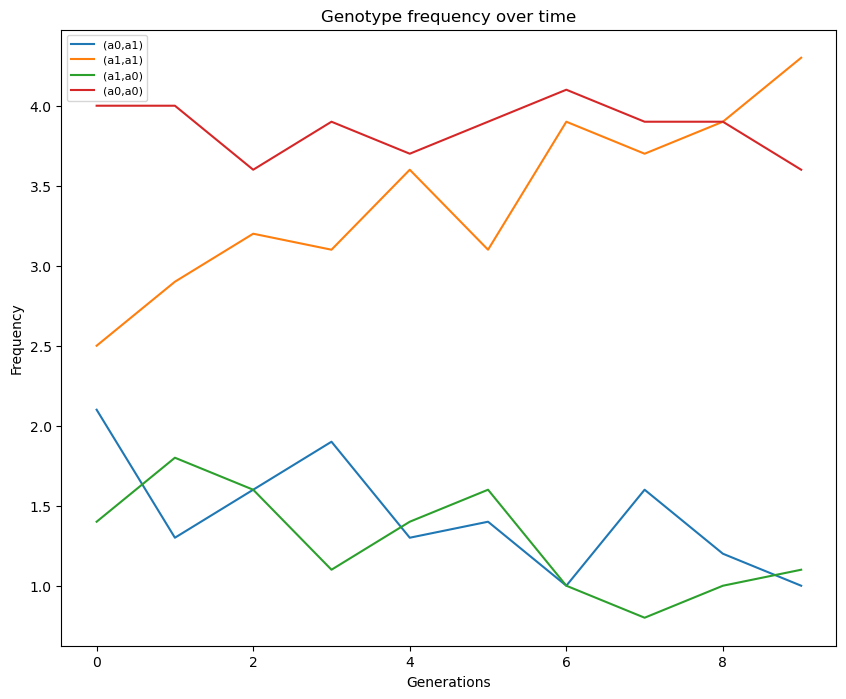

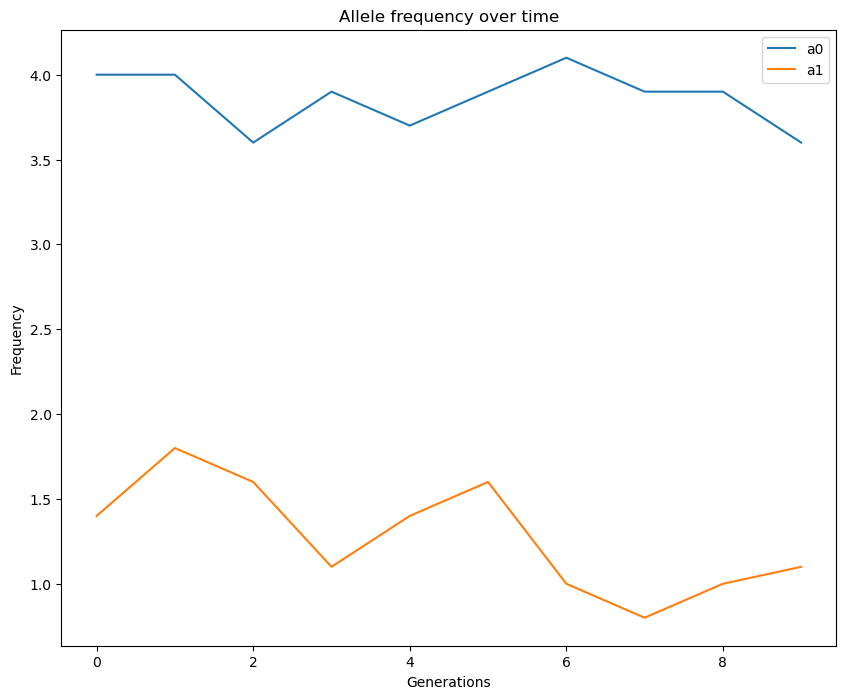

In [136]:
# anything with 1 is good
# FINDINGS: When one homogenous gene is particularly bad in comparison to all other genes, gene converges towards the other homogenous gene (the 0 allele dies out)

unfitness_dict = {
    Genotype(0, (0,0)): 0.2,  # 00 quite bad
    Genotype(0, (1,0)): 0.1,  # 10 not bad
    Genotype(0, (0,1)): 0.1,  # 01 not bad
    Genotype(0, (1,1)): 0.1,  # 11 not bad
}

for i in range(10):
    for j in range(10):
        g = Genotype(0, (i,j))
        if j == 1 or i == 1:
            unfitness_dict[g] = 0.1
        else:
            unfitness_dict[g] = 0.2

special_line_styles={
    '(1, 1)': '--',
    }

gene_freqs_over_time = run_simulation(num_genes=1, mu=0.0001, pop_size=10, generations=10, simulations=10, unfitness_dict=unfitness_dict, ick_dict={}, mating=Population.selective_random_mating, special_line_styles=special_line_styles)

print(gene_freqs_over_time)

allele_freq_over_time = get_allele_freq_over_time(gene_freqs_over_time)
plot_freqs_over_time(allele_freq_over_time, fontsize='10', figsize=(10,8), title='Allele frequency over time')

print(allele_freq_over_time)

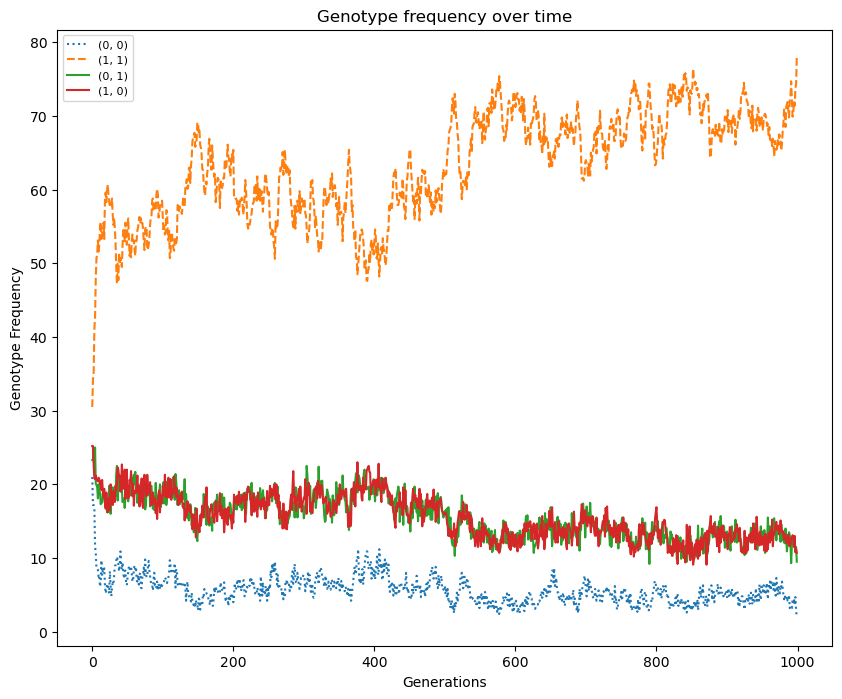

In [13]:
# What about when heterogenous genes are slightly better than the "good" homo gene?
# FINDINGS: 'good' homo gene still prevails quickly, but 'bad' homo gene doesn't die out completley
unfitness_dict = {
    Genotype(0, (0,0)): 0.3,  # 00 quite bad
    Genotype(0, (1,0)): 0,  # 10 not bad
    Genotype(0, (0,1)): 0,  # 01 not bad
    Genotype(0, (1,1)): 0.1,  # 11 not bad
}

gene_freqs_over_time = run_simulation(mu=0, pop_size=100, generations=1000, simulations=10, unfitness_dict=unfitness_dict, ick_dict={}, mating=Population.selective_random_mating)

# Part 2 - Evolution of positive mutations:
### Is it true that sexual reproduction speeds up evolution, by fastening the time required for generating an individual that accumulates more than one (say, two or three) positive unrelated mutations?


In [ ]:
# FINDINGS: When one homogenous gene is particularly bad in comparison to all other genes, gene converges towards the other homogenous gene (the 0 allele dies out)

unfitness_dict = {
    Genotype(0, (0,0)): 0.1,  # 00 quite bad
    Genotype(0, (1,0)): 0.,  # 10 not bad
    Genotype(0, (0,1)): 0.9,  # 01 not bad
    Genotype(0, (1,1)): 0.1,  # 11 not bad
    Genotype(1, (0,0)): 0.1,  # 00 quite bad
    Genotype(1, (1,0)): 0.,  # 10 not bad
    Genotype(1, (0,1)): 0.9,  # 01 not bad
    Genotype(1, (1,1)): 0.1,  # 11 not bad
}

gene_freqs_over_time = run_simulation(num_genes=2, mu=0, pop_size=10, generations=10, simulations=10, unfitness_dict=unfitness_dict, ick_dict={}, mating=Population.selective_random_mating)

allele_freq_over_time = get_allele_freq_over_time(gene_freqs_over_time)
plot_freqs_over_time(allele_freq_over_time, fontsize='10')

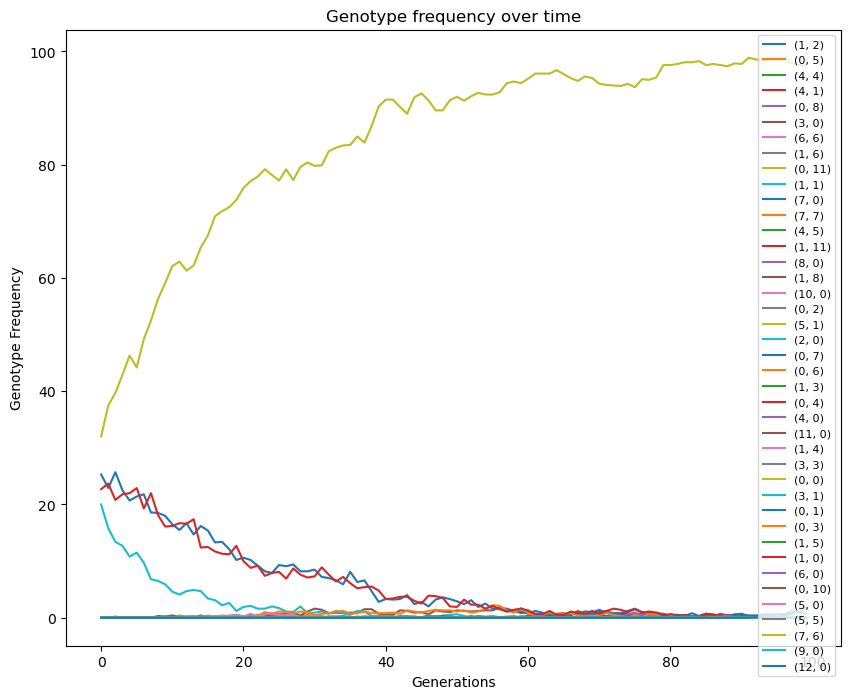

In [35]:
'''
2 is a mutation
12 is a bit better than 11. 22 is much better than 12.

And similarly for B, C.

How long does it take to evolve into aa, bb, cc?  Does it depend on mutation rate, bad luck probability?  How?
'''
unfitness_dict = {
    Genotype(0, (1,1)): 0.2,
    Genotype(0, (2,0)): 0.05,
    Genotype(0, (0,2)): 0.05,
    Genotype(0, (1,2)): 0.05,
    Genotype(0, (2,1)): 0.05,
    Genotype(0, (2,2)): 0.0,
}
for i in range(20):
    for j in range(20):
        if Genotype(0, (i,j)) not in unfitness_dict.keys():
            unfitness_dict[Genotype(0, (i,j))] = 0.2

special_line_styles={
    '(2, 2)': '--',
    }

# print(unfitness_dict)

gene_freqs_over_time = run_simulation(mu=0.0005, pop_size=100, generations=100, simulations=10, unfitness_dict=unfitness_dict, ick_dict={}, mating=Population.selective_random_mating, num_starting_alleles=2, special_line_styles=special_line_styles)

{(0, (0, 0)): 0.2, (0, (0, 1)): 0.2, (0, (0, 2)): 0.2, (0, (0, 3)): 0.1, (0, (0, 4)): 0.1, (0, (0, 5)): 0.2, (0, (0, 6)): 0.2, (0, (0, 7)): 0.2, (0, (0, 8)): 0.2, (0, (0, 9)): 0.2, (0, (0, 10)): 0.2, (0, (0, 11)): 0.2, (0, (0, 12)): 0.2, (0, (0, 13)): 0.2, (0, (0, 14)): 0.2, (0, (0, 15)): 0.2, (0, (0, 16)): 0.2, (0, (0, 17)): 0.2, (0, (0, 18)): 0.2, (0, (0, 19)): 0.2, (0, (0, 20)): 0.2, (0, (0, 21)): 0.2, (0, (0, 22)): 0.2, (0, (0, 23)): 0.2, (0, (0, 24)): 0.2, (0, (0, 25)): 0.2, (0, (0, 26)): 0.2, (0, (0, 27)): 0.2, (0, (0, 28)): 0.2, (0, (0, 29)): 0.2, (0, (0, 30)): 0.2, (0, (0, 31)): 0.2, (0, (0, 32)): 0.2, (0, (0, 33)): 0.2, (0, (0, 34)): 0.2, (0, (0, 35)): 0.2, (0, (0, 36)): 0.2, (0, (0, 37)): 0.2, (0, (0, 38)): 0.2, (0, (0, 39)): 0.2, (0, (0, 40)): 0.2, (0, (0, 41)): 0.2, (0, (0, 42)): 0.2, (0, (0, 43)): 0.2, (0, (0, 44)): 0.2, (0, (0, 45)): 0.2, (0, (0, 46)): 0.2, (0, (0, 47)): 0.2, (0, (0, 48)): 0.2, (0, (0, 49)): 0.2, (0, (0, 50)): 0.2, (0, (0, 51)): 0.2, (0, (0, 52)): 0.2, (0

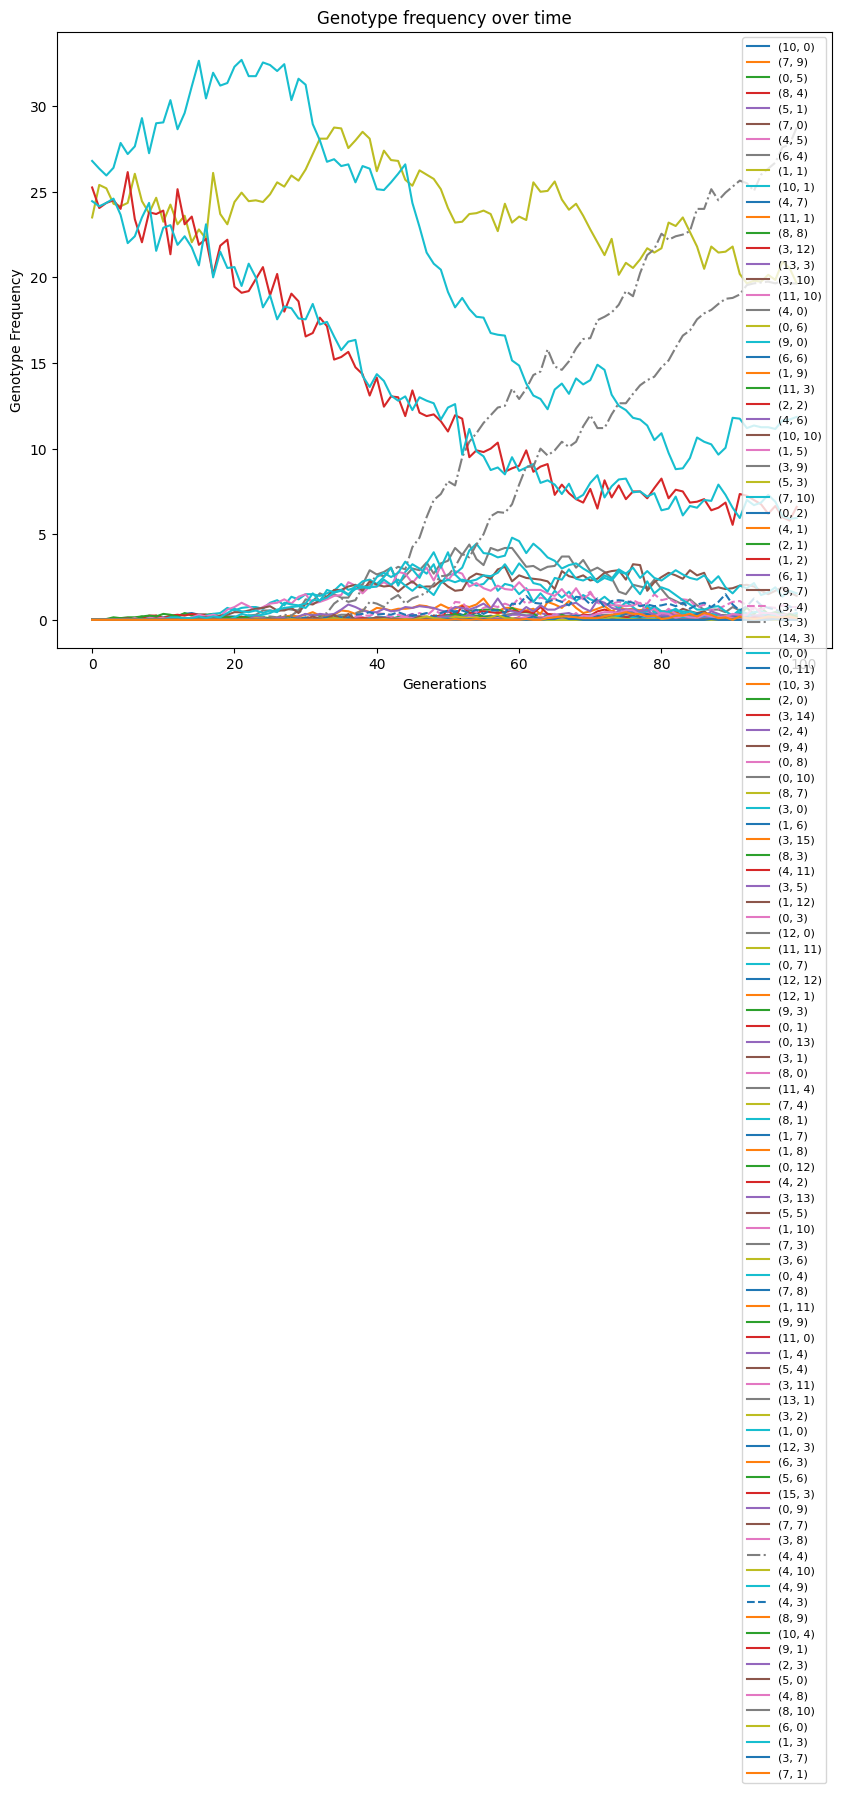

In [ ]:
'''
10 is a bit better than 11.  00 is much better than 10.

And similarly for B, C.

How long does it take to evolve into aa, bb, cc?  Does it depend on mutation rate, bad luck probability?  How?
'''

# FINDINGS: with mutation alone badness > 0.2, the mutation just died out before finding 'good combo', had to make it a good mutation alone to see anything happen
#   So most mutations dont find their soulmate mutation :(
#   Deep...


# special mutations that are NOT GOOD alone, but GREAT together
special_mutations = [3, 4]
unfitness_dict = {}
for i in range(100):
    for j in range(100):
        if (i in special_mutations or j in special_mutations):
            # not good seperate
            if (i != j):
                # with > 0.2 the mutation just died, had to make it a good mutation alone to see anything happen
                unfitness_dict[Genotype(0, (i,j))] = 0.1
            # GREAT together
            else:
                unfitness_dict[Genotype(0, (i,j))] = 0
        else:
            unfitness_dict[Genotype(0, (i,j))] = 0.2
print(unfitness_dict)

special_line_styles={
    '(3, 4)': '--',
    '(4, 3)': '--',
    '(3, 3)': '-.',
    '(4, 4)': '-.',
    }

gene_freqs_over_time = run_simulation(mu=0.001, pop_size=100, generations=200, simulations=10, unfitness_dict=unfitness_dict, mating=Population.selective_random_mating, special_line_styles=special_line_styles)

# Differences between mating preferences and survival chance
### What difference is there between genes that effect survivorship and genes that effect mating selection?
1. Is one more powerful than the other?
2. What if they're both in competition? (i.e. 'hold my beer' traits)

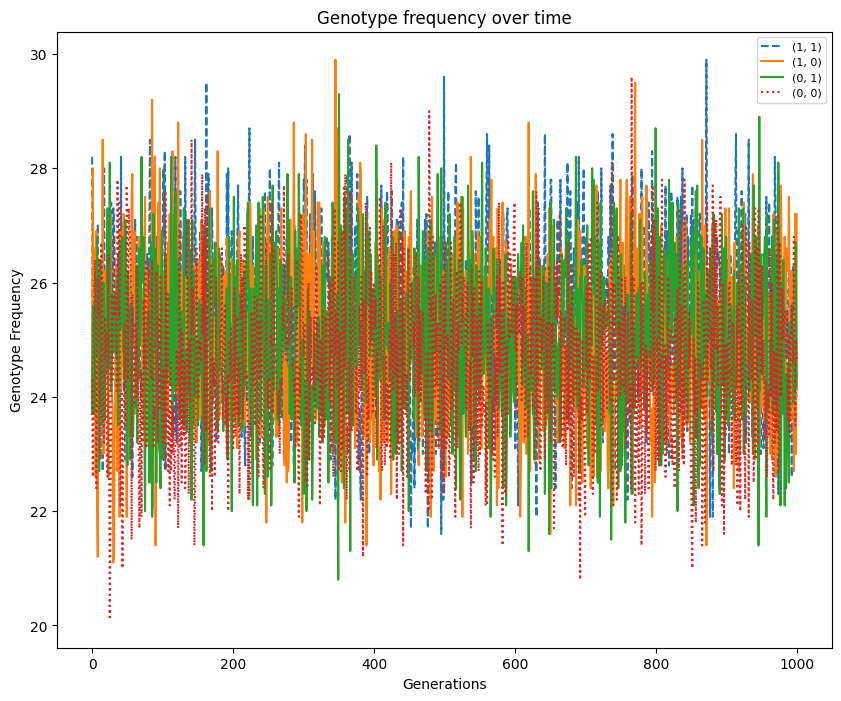

In [ ]:
# (0,0) is equally bad for survivorship as (1,1) is for mating
# So they're equally weighted?

unfitness_dict = {
    Genotype(0, (0,0)): 0.99, # (0,0) bad gene for survival
    Genotype(0, (1,0)): 0.2,
    Genotype(0, (0,1)): 0.2,
    Genotype(0, (1,1)): 0.2,
}
ick_dict = {
    Genotype(0, (0,0)): 0.2,
    Genotype(0, (1,0)): 0.2,
    Genotype(0, (0,1)): 0.2,
    Genotype(0, (1,1)): 0.98, # (1,1) is bad gene for reproduction
}

gene_freqs_over_time = run_simulation(mu=0, pop_size=100, generations=1000, simulations=10, unfitness_dict=unfitness_dict, ick_dict=ick_dict, mating=Population.selective_random_mating)

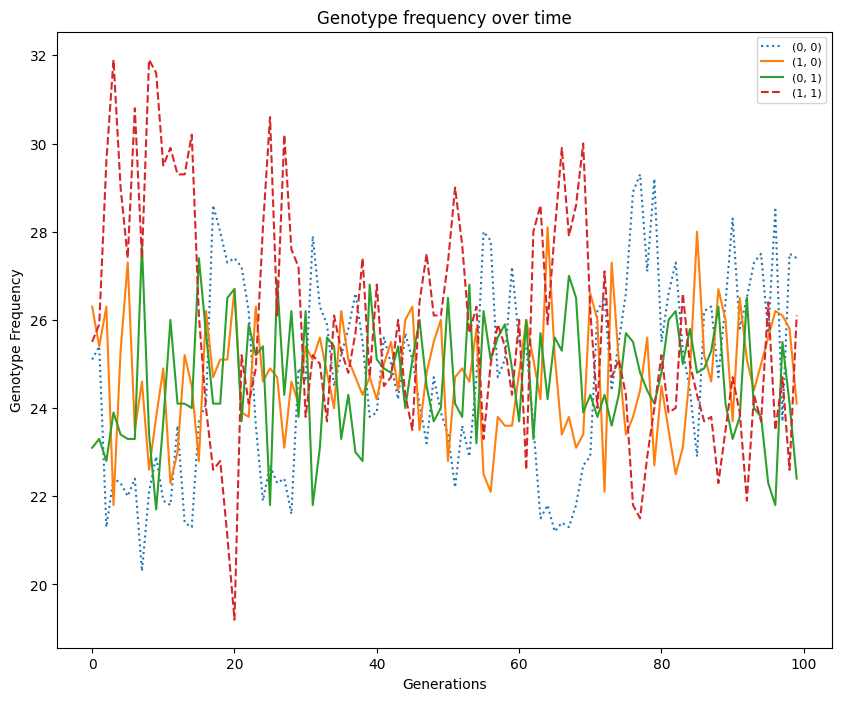

In [ ]:
# (0,0) is equally bad for survivorship as (1,1) is for mating
# So they're equally weighted?

unfitness_dict = {
    Genotype(0, (0,0)): 0.5, # (0,0) bad gene for survival
    Genotype(0, (1,0)): 0.2,
    Genotype(0, (0,1)): 0.2,
    Genotype(0, (1,1)): 0.2,
}
ick_dict = {
    Genotype(0, (0,0)): 0.2,
    Genotype(0, (1,0)): 0.2,
    Genotype(0, (0,1)): 0.2,
    Genotype(0, (1,1)): 0.5, # (1,1) is bad gene for reproduction
}

gene_freqs_over_time = run_simulation(mu=0, pop_size=100, generations=100, simulations=10, unfitness_dict=unfitness_dict, ick_dict=ick_dict, mating=Population.selective_random_mating)

Evaluating unequal bias:

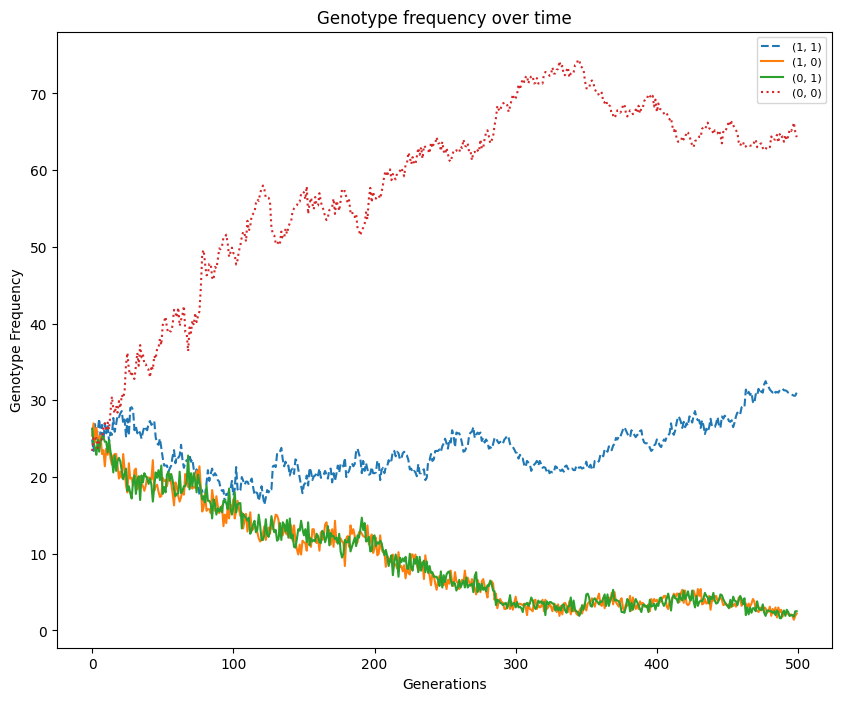

In [ ]:
# Heterozygotes die, homozygotes dont mate
# FINDINGS: Doesn't fully converge but going towards homozygotes

unfitness_dict = {
    Genotype(0, (0,0)): 0,
    Genotype(0, (1,0)): 0.2,
    Genotype(0, (0,1)): 0.2,
    Genotype(0, (1,1)): 0,
}
ick_dict = {
    Genotype(0, (0,0)): 0.2,
    Genotype(0, (1,0)): 0,
    Genotype(0, (0,1)): 0,
    Genotype(0, (1,1)): 0.2,
}

gene_freqs_over_time = run_simulation(mu=0, pop_size=100, generations=500, simulations=10, unfitness_dict=unfitness_dict, ick_dict=ick_dict, mating=Population.selective_random_mating)

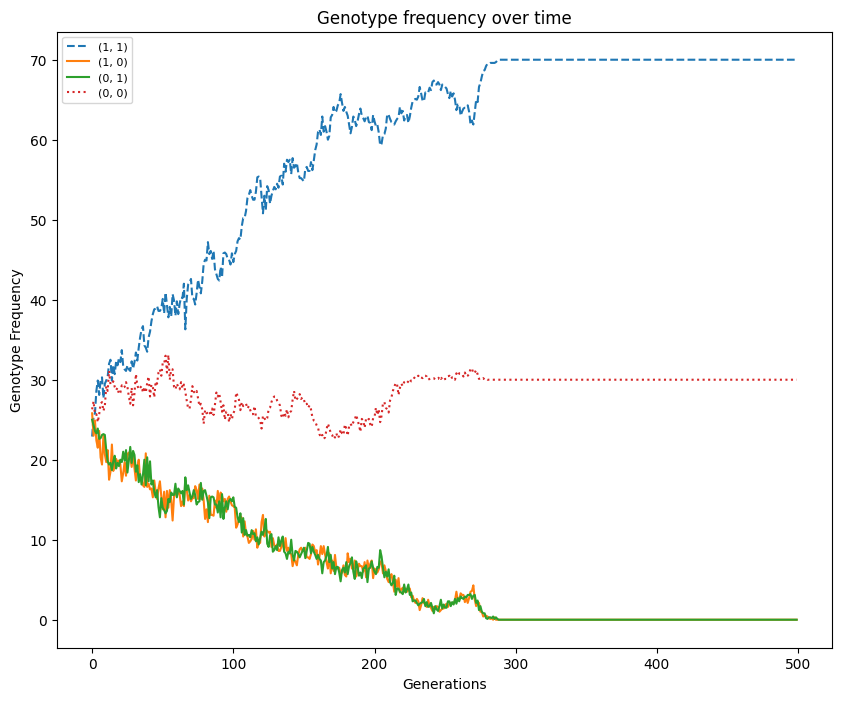

In [ ]:
# Heterozygotes dont mate, homozygotes die
# FINDINGS: Converges to Homozygotes...
#   They'd rather have less chance of survival than of mating???
unfitness_dict = {
    Genotype(0, (0,0)): 0.2,
    Genotype(0, (1,0)): 0.,
    Genotype(0, (0,1)): 0.,
    Genotype(0, (1,1)): 0.2,
}
ick_dict = {
    Genotype(0, (0,0)): 0.,
    Genotype(0, (1,0)): 0.2,
    Genotype(0, (0,1)): 0.2,
    Genotype(0, (1,1)): 0.,
}

gene_freqs_over_time = run_simulation(mu=0, pop_size=100, generations=500, simulations=10, unfitness_dict=unfitness_dict, ick_dict=ick_dict, mating=Population.selective_random_mating)

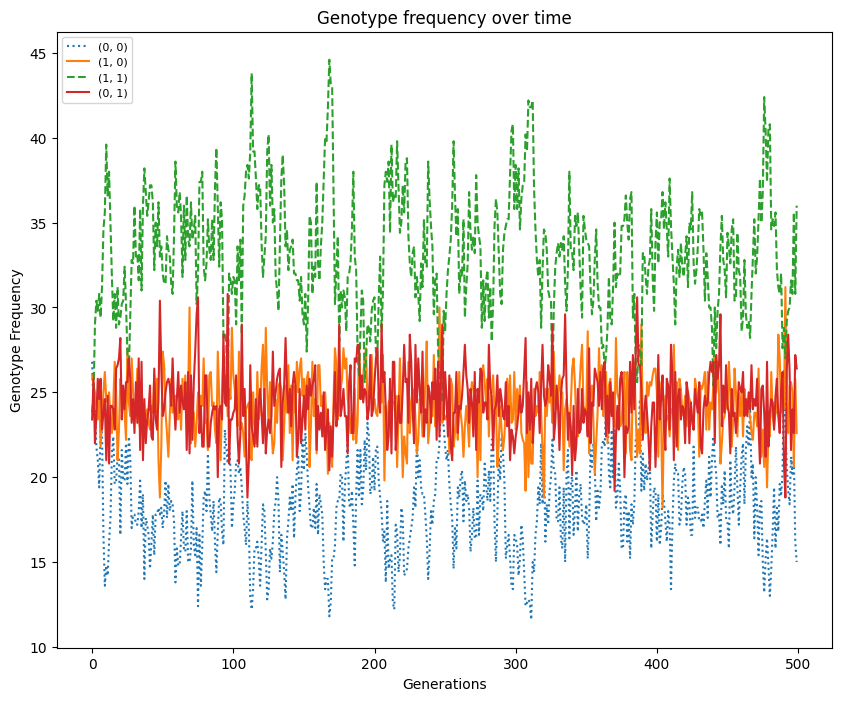

In [ ]:
# (0,0) is slightly worse for survivorship than (1,1) is for mating
# FINDINGS: of course the less detremental one would persevere, but other doesnt die out - maybe because heterozygotes are best bet here?

unfitness_dict = {
    Genotype(0, (0,0)): 0.5, # (0,0) is bad gene for survival
    Genotype(0, (1,0)): 0.1,
    Genotype(0, (0,1)): 0.1,
    Genotype(0, (1,1)): 0.1,
}
ick_dict = {
    Genotype(0, (0,0)): 0.1,
    Genotype(0, (1,0)): 0.1,
    Genotype(0, (0,1)): 0.1,
    Genotype(0, (1,1)): 0.4, # (1,1) is bad gene for reproduction
}

gene_freqs_over_time = run_simulation(mu=0, pop_size=100, generations=500, simulations=5, unfitness_dict=unfitness_dict, ick_dict=ick_dict, mating=Population.selective_random_mating)

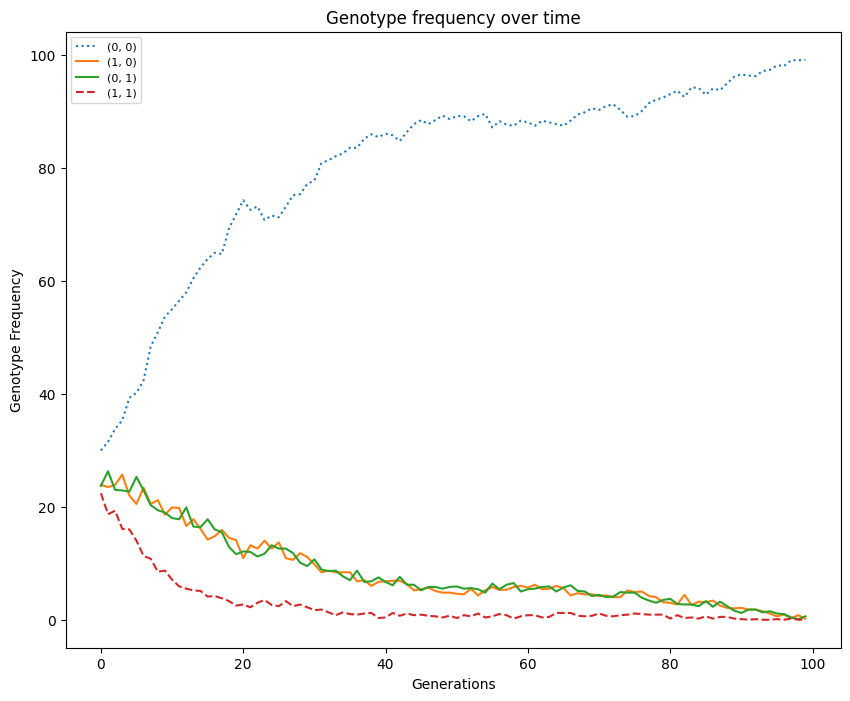

In [ ]:
# Any 0-having allele more likely to die than be chosen mate, but (1,1) not likely chosen to mate
# FINDINGS: converge to (0,0) - likely to mate and still low chance of death
#   Can we take this to the limit? at what point would converge to (1,1)?
unfitness_dict = {
    Genotype(0, (0,0)): 0.1,
    Genotype(0, (1,0)): 0.1,
    Genotype(0, (0,1)): 0.1,
    Genotype(0, (1,1)): 0,
}
ick_dict = {
    Genotype(0, (0,0)): 0,
    Genotype(0, (1,0)): 0.,
    Genotype(0, (0,1)): 0.,
    Genotype(0, (1,1)): 0.3,
}

gene_freqs_over_time = run_simulation(mu=0, pop_size=100, generations=100, simulations=10, unfitness_dict=unfitness_dict, ick_dict=ick_dict, mating=Population.selective_random_mating)

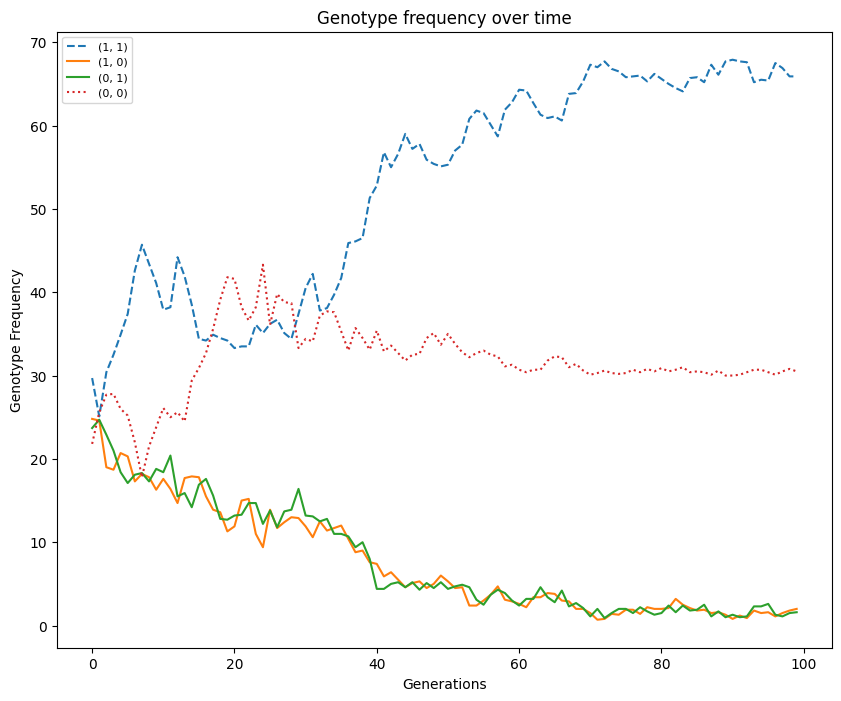

In [ ]:
# Above taken to the limit... (how bad does (0,0) have to get for (1,1) to be chosen? does it need to surpass (1,1)'s badness?)
# Any 0-having allele more likely to die than be chosen mate, but (1,1) not likely chosen to mate
# FINDINGS: Only at 0.89 does it converge (sometimes!) to (1,1) - likely to survive but low chance of mating
unfitness_dict = {
    Genotype(0, (0,0)): 0.89,
    Genotype(0, (1,0)): 0.89,
    Genotype(0, (0,1)): 0.89,
    Genotype(0, (1,1)): 0,
}
ick_dict = {
    Genotype(0, (0,0)): 0,
    Genotype(0, (1,0)): 0.,
    Genotype(0, (0,1)): 0.,
    Genotype(0, (1,1)): 0.9,
}

gene_freqs_over_time = run_simulation(mu=0, pop_size=100, generations=100, simulations=10, unfitness_dict=unfitness_dict, ick_dict=ick_dict, mating=Population.selective_random_mating)

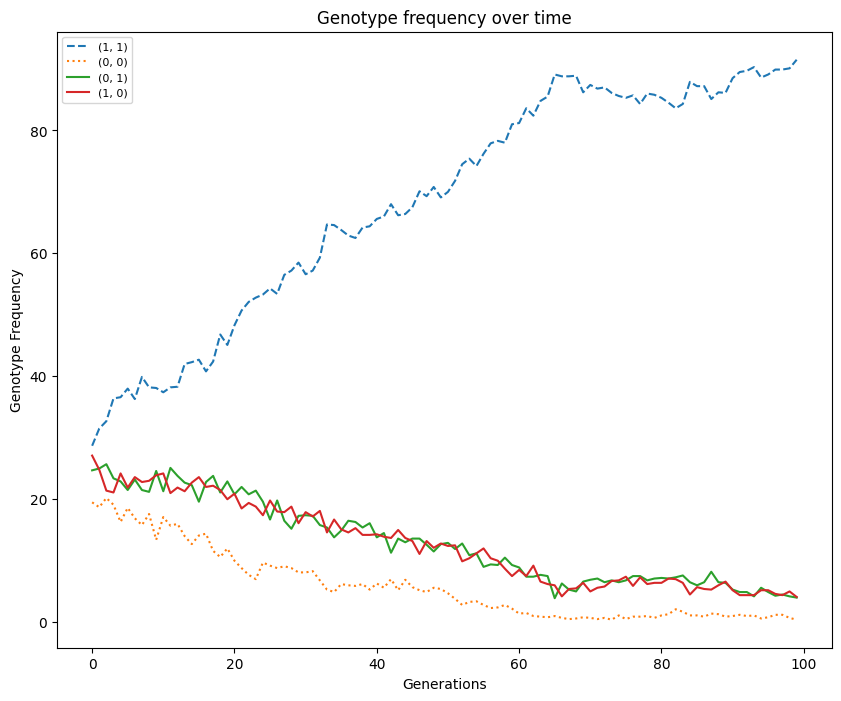

In [ ]:
# (0,0) is more prone to death, but (1,1) is not likely to reproduce
# but here the death threat is slightly higher than reproductive
unfitness_dict = {
    Genotype(0, (0,0)): 0.5, # bad gene for survival
    Genotype(0, (1,0)): 0.3,
    Genotype(0, (0,1)): 0.3,
    Genotype(0, (1,1)): 0.2,
}
ick_dict = {
    Genotype(0, (0,0)): 0.2,
    Genotype(0, (1,0)): 0.3,
    Genotype(0, (0,1)): 0.3,
    Genotype(0, (1,1)): 0.4, # bad gene for reproduction
}

gene_freqs_over_time = run_simulation(mu=0, pop_size=100, generations=100, simulations=10, unfitness_dict=unfitness_dict, ick_dict=ick_dict, mating=Population.selective_random_mating)

TODO: graph overall allele frequency/presence (not just genes)

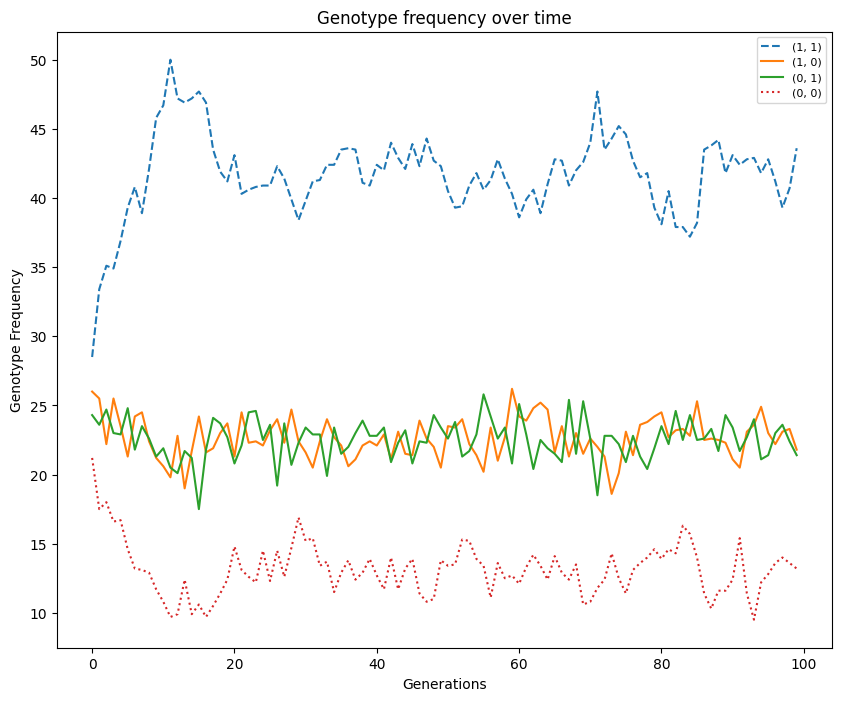

In [ ]:
# (0,0) is more prone to death, but (1,1) is not likely to reproduce
# but here the reproductive threat is slightly higher than death
unfitness_dict = {
    Genotype(0, (0,0)): 0.2, # bad gene
    Genotype(0, (1,0)): 0,
    Genotype(0, (0,1)): 0,
    Genotype(0, (1,1)): 0.,
}
ick_dict = {
    Genotype(0, (0,0)): 0.2,
    Genotype(0, (1,0)): 0.,
    Genotype(0, (0,1)): 0.,
    Genotype(0, (1,1)): 0.2, # bad gene
}

gene_freqs_over_time = run_simulation(mu=0, pop_size=100, generations=100, simulations=10, unfitness_dict=unfitness_dict, ick_dict=ick_dict, mating=Population.selective_random_mating)


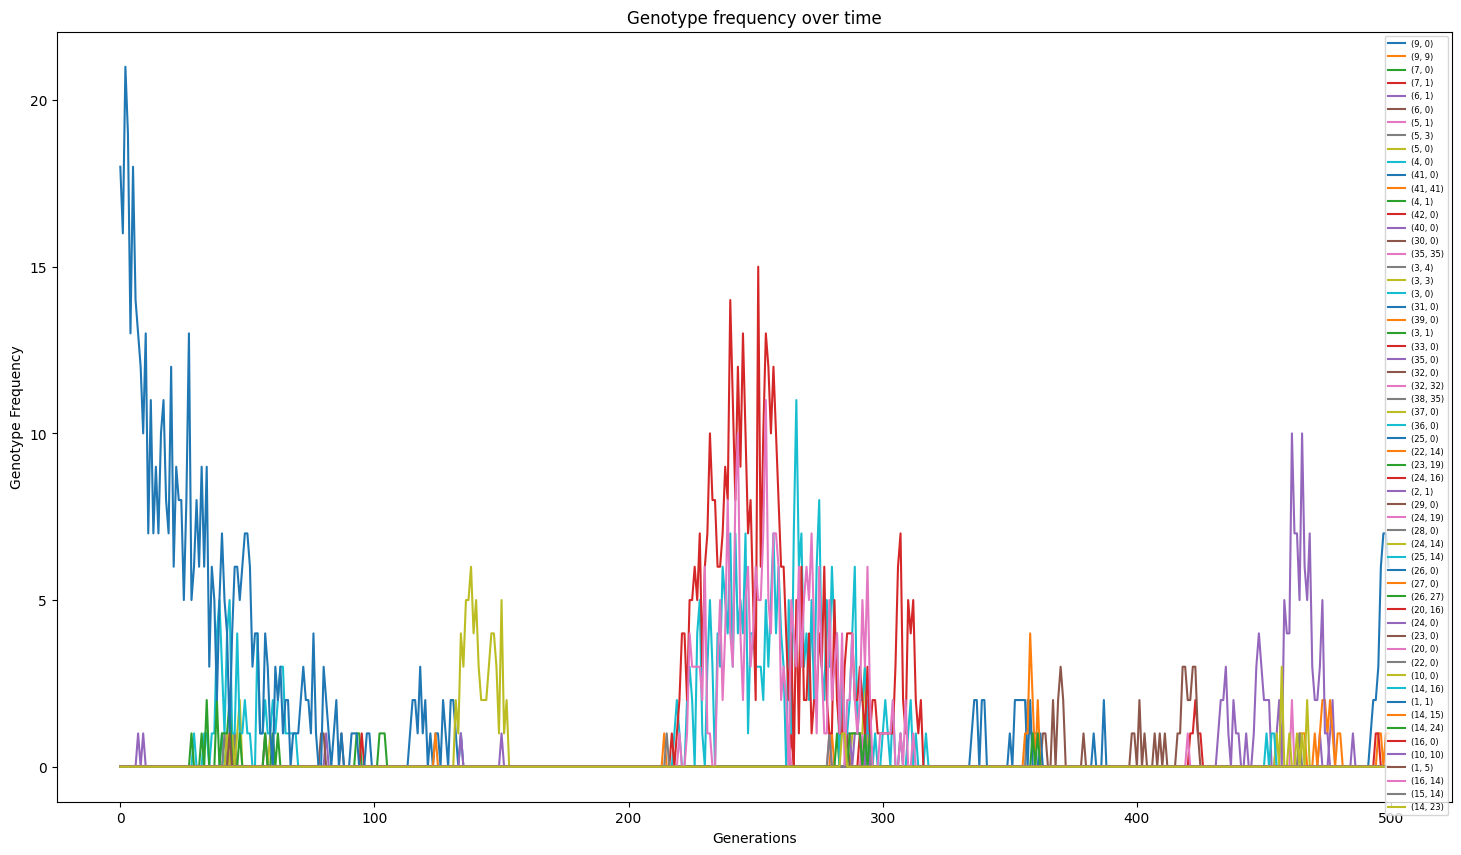

In [ ]:
# Random Mating
mu=0.001
pop_size = 100
init_pop = [Individual.create_random(num_genes=1, mu=mu) for _ in range(pop_size)]
pop = Population(init_pop)
random_mating_f_ls = []
random_mating_f_exp = []

gene_frequencies = []
all_genes_seen = []

for j in range(500):
    pop = pop.get_generation(Population.random_mating, highest_allele=pop.highest_allele, mu=mu)

    F = pop.calculate_F_heterozygote()
    f_exp = pop.get_estimated_fst(random_mating_f_ls)
    random_mating_f_exp.append(f_exp)

    random_mating_f_ls.append(F)

    freq = pop.get_genotype_frequencies(0)
    gene_frequencies.append(freq)
    all_genes_seen = list(set(all_genes_seen + list(freq.keys())))

gene_freqs_over_time = get_temporal_frequency(all_genes_seen, gene_frequencies, filter_out_percent=0.5)

plot_gene_freqs_over_time(gene_freqs_over_time)